### Import the needed package

In [1]:
# package to get the custom modules
import sys
# package for handling the environment variables
from dotenv import load_dotenv

# add the path to the custom modules
sys.path.insert(0, './../')
# load the environment variables
load_dotenv()

# package for handling the files
import os
# package for handling random numbers
from random import randint
# package for handling array
import numpy as np
# package for handling the metadata
import pandas as pd
# the custom module for handling the data
import utilities as utils
# package for handling the machine learning model
import tensorflow as tf

c:\Users\Acer\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Acer\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

### Global variables

In [2]:
path_full = os.environ.get("ORI_PATH")
path_dataset = os.path.join(path_full, "datasets", "splitted", "augmented", "test")
path_cdr_data = os.path.join(path_full, "data", "cdr_dataset.csv")

### Get CDR value from the dataset

In [3]:
cdr_data = pd.read_csv(path_cdr_data)
cdr_data.head(5)

,id,label,eye_side,a_cdr,v_cdr,h_cdr
0,fff_0_111784_l_y_mask,0,l,0.340206,0.633803,0.560606
1,fff_0_111784_r_y_mask,0,r,0.300445,0.541667,0.538462
2,fff_0_113060_l_1_mask,0,l,0.473950,0.686275,0.670000
3,fff_0_113060_l_2_mask,0,l,0.516781,0.777778,0.680000
4,fff_0_113060_l_3_mask,0,l,0.491304,0.721154,0.697917


### Get the existing test image

In [4]:
# get the fundus images list from the testset
f_images = [img for img in os.listdir(path_dataset) if img.endswith(".jpg")]
# convert the list to a dataframe
test_img = pd.DataFrame(f_images, columns=["image"])

# extract the information
test_img["id"] = test_img["image"].apply(lambda x: x.split(".")[0])                 # get the id of the image
test_img = test_img[['id', 'image']]                                                # rearrange the columns order
test_img["label"] = test_img["id"].apply(lambda x: x.split("_")[1])                 # get the label of the image
test_img["eye_side"] = test_img["id"].apply(lambda x: x.split("_")[3])              # get the eye side of the image
test_img["image"] = test_img["image"].apply(lambda x: os.path.join(path_dataset, x))# get the full path of the image
test_img.rename(columns={"image": "path"}, inplace=True)                            # rename the column image to path

# show the data
test_img.drop(columns=["path"]).head(5)

,id,label,eye_side
0,fff_0_115058_l_1_aug,0,l
1,fff_0_115058_r_3_aug,0,r
2,fff_0_121076_r_1_aug,0,r
3,fff_0_121362_l_1_aug,0,l
4,fff_0_121362_l_3_aug,0,l


### Get the model

In [5]:
Unet_model = utils.custom_load_model(os.path.join(path_full,
                                                "data",
                                                "model",
                                                "unet_model_aug.h5"))

MNet_model = utils.custom_load_model(os.path.join(path_full,
                                                "data",
                                                "model",
                                                "mnet_model_aug.h5"))

Efnet_model = utils.custom_load_model(os.path.join(path_full,
                                                "data",
                                                "model",
                                                "efnet_model_aug.h5"))

### Visualize the extracted image

#### Unet

fff_0_121362_l_3_aug


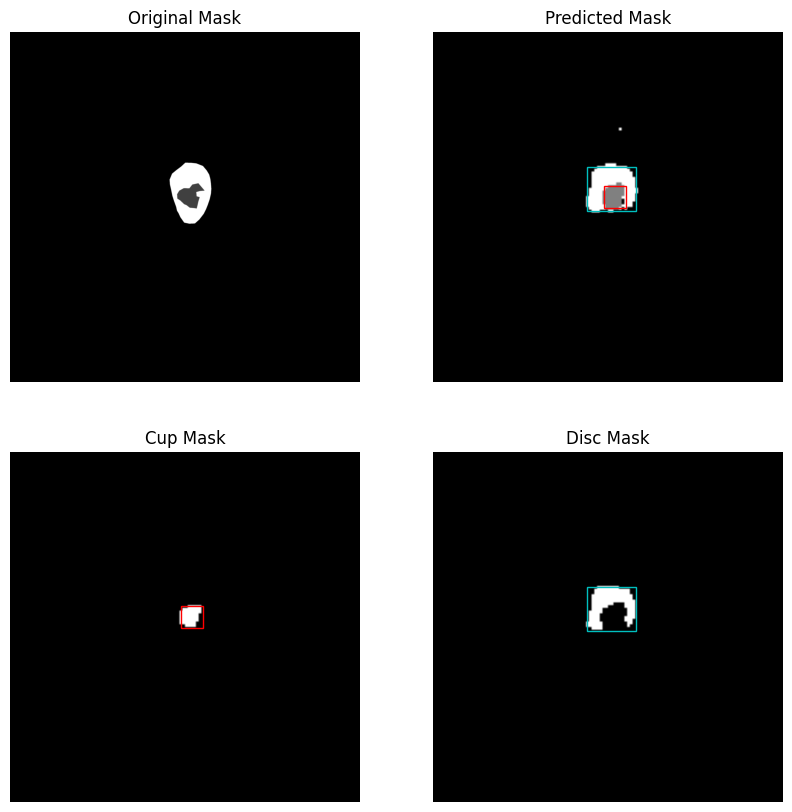

{'area_cdr': 0.24401913875598086, 'horizontal_cdr': 0.4444444444444444, 'vertical_cdr': 0.5}


In [6]:
# set the random index
# rand_idx = randint(0, len(test_img))
rand_idx = 4
# show the image id
print(test_img.id[rand_idx])
# visualize the image
print(utils.ev_cdr(
    model=Unet_model,
    img_path=test_img.path[rand_idx],
    mask_path=os.path.join(path_dataset,
                            f"{test_img.id[rand_idx].replace('aug', 'mask')}.png"),
    threshold=.64,
    visualize=True
))

#### MobileNet

fff_0_121362_l_3_aug


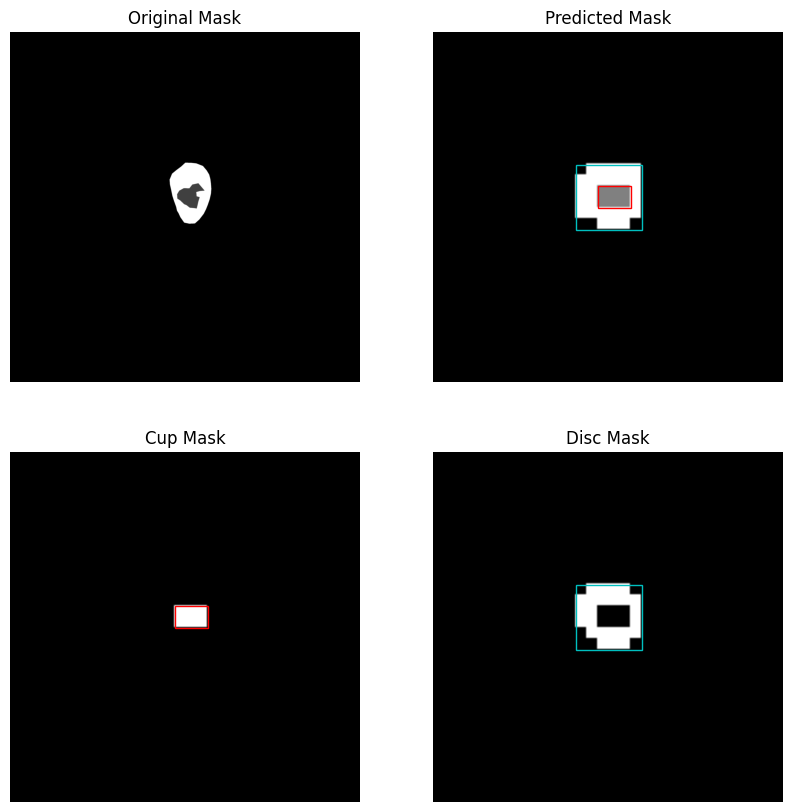

{'area_cdr': 0.2, 'horizontal_cdr': 0.5, 'vertical_cdr': 0.3333333333333333}


In [7]:
# set the random index
# rand_idx = randint(0, len(test_img))
rand_idx = 4
# show the image id
print(test_img.id[rand_idx])
# visualize the image
print(utils.ev_cdr(
    model=MNet_model,
    img_path=test_img.path[rand_idx],
    mask_path=os.path.join(path_dataset,
                            f"{test_img.id[rand_idx].replace('aug', 'mask')}.png"),
    threshold=.64,
    visualize=True
))

#### EfficientNet

fff_0_121362_l_3_aug


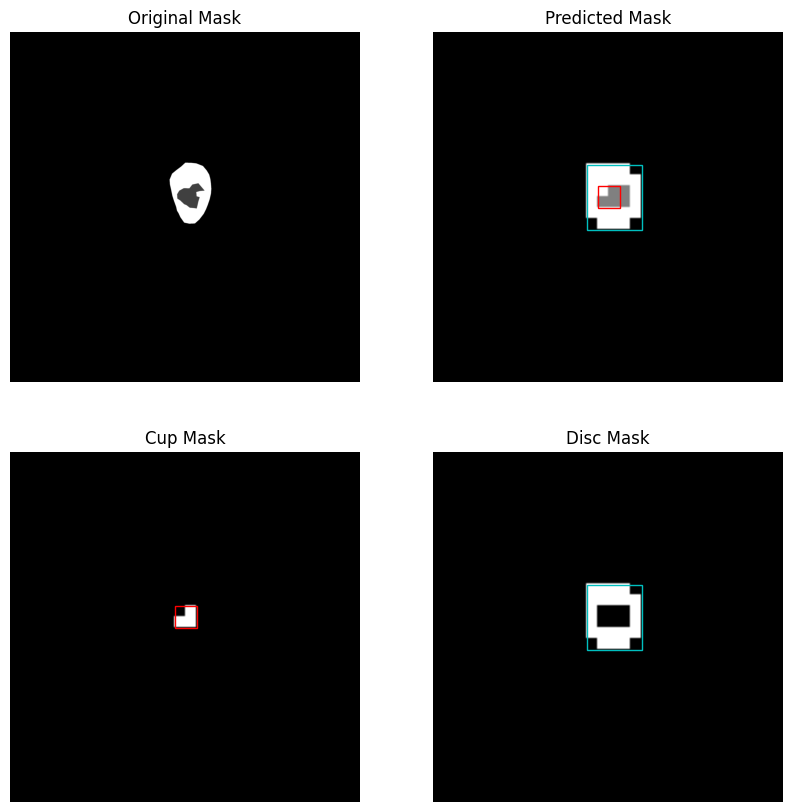

{'area_cdr': 0.125, 'horizontal_cdr': 0.4, 'vertical_cdr': 0.3333333333333333}


In [8]:
# set the random index
# rand_idx = randint(0, len(test_img))
rand_idx = 4
# show the image id
print(test_img.id[rand_idx])
# visualize the image
print(utils.ev_cdr(
    model=Efnet_model,
    img_path=test_img.path[rand_idx],
    mask_path=os.path.join(path_dataset,
                            f"{test_img.id[rand_idx].replace('aug', 'mask')}.png"),
    threshold=.64,
    visualize=True
))

### Get the CDR value from the predicted mask

#### Unet

In [9]:
# create an empty dataframe to store the results
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])

# get the CDR value for each image
for i, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(Unet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .2,)
    # populate the dataframe with the given cdr values
    ev_cdr.loc[i] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

# show the data
ev_cdr.head(5)

,id,a_cdr,v_cdr,h_cdr
0,fff_0_115058_l_1_aug,0.279133,5.500000,11.000000
1,fff_0_115058_r_3_aug,0.260101,12.000000,6.000000
2,fff_0_121076_r_1_aug,0.258929,0.521739,0.526316
3,fff_0_121362_l_1_aug,0.295181,1.714286,1.571429
4,fff_0_121362_l_3_aug,0.236915,2.400000,2.500000


#### MobileNet

In [10]:
# create an empty dataframe to store the results
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])

# get the CDR value for each image
for i, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(MNet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .2,)
    # populate the dataframe with the given cdr values
    ev_cdr.loc[i] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

# show the data
ev_cdr.head(5)

,id,a_cdr,v_cdr,h_cdr
0,fff_0_115058_l_1_aug,0.195122,0.375000,0.500000
1,fff_0_115058_r_3_aug,0.230769,0.428571,0.571429
2,fff_0_121076_r_1_aug,0.121212,0.333333,0.285714
3,fff_0_121362_l_1_aug,0.181818,0.571429,0.333333
4,fff_0_121362_l_3_aug,0.194444,0.250000,0.666667


#### EfficientNet

In [11]:
# create an empty dataframe to store the results
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])

# get the CDR value for each image
for i, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(Efnet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .2,)
    # populate the dataframe with the given cdr values
    ev_cdr.loc[i] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

# show the data
ev_cdr.head(5)

,id,a_cdr,v_cdr,h_cdr
0,fff_0_115058_l_1_aug,0.218750,0.428571,0.500000
1,fff_0_115058_r_3_aug,0.307692,0.500000,0.800000
2,fff_0_121076_r_1_aug,0.142857,0.333333,0.333333
3,fff_0_121362_l_1_aug,0.166667,0.428571,0.333333
4,fff_0_121362_l_3_aug,0.193548,0.285714,0.600000


### Get the Loss of predicted CDR with the dataset CDR

In [12]:
########## count the loss value ##########
# initialize an empty dictionary to store the results
data = {}
# iterate over the threshold values
for i in np.linspace(.15, .8, 25):
    # round the threshold value to two decimal places
    threshold = round(i, 2)
    print(f"Threshold: {threshold}")
    # create an empty dataframe to store the results
    ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
    # get the CDR value for each image
    for idx, row in test_img.iterrows():
        # get the cdr value
        cdr_value = utils.ev_cdr(Unet_model,
                                row.path,
                                os.path.join(path_dataset,
                                            f"{row.id.replace('aug', 'mask')}.png"),
                                threshold,)
        # populate the dataframe with the given cdr values
        ev_cdr.loc[idx] = [row.id,
                        cdr_value["area_cdr"],
                        cdr_value["vertical_cdr"],
                        cdr_value["horizontal_cdr"]]
    # get the loss value
    loss = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]),
                                ev_cdr)
    # populate the dictionary with the given threshold and loss value
    data[threshold] = loss

Threshold: 0.15
Threshold: 0.18
Threshold: 0.2
Threshold: 0.23
Threshold: 0.26
Threshold: 0.29
Threshold: 0.31
Threshold: 0.34
Threshold: 0.37
Threshold: 0.39
Threshold: 0.42
Threshold: 0.45
Threshold: 0.48
Threshold: 0.5
Threshold: 0.53
Threshold: 0.56
Threshold: 0.58
Threshold: 0.61
Threshold: 0.64
Threshold: 0.66
Threshold: 0.69
Threshold: 0.72
Threshold: 0.75
Threshold: 0.77
Threshold: 0.8


In [13]:
########## populate the loss dataframe ##########
# create an empty dataframe to store the results
loss_df = pd.DataFrame(columns=['threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values
for item, value in data.items():
    loss_df.loc[len(loss_df)] = [item,
                                value['a_mse'],
                                value['a_mae'],
                                value['a_huber'],
                                value['h_mse'],
                                value['h_mae'],
                                value['h_huber'],
                                value['v_mse'],
                                value['v_mae'],
                                value['v_huber']]

# sort the dataframe by the loss value
loss_df.sort_values(by="v_huber", ascending=True, inplace=True)
# loss_df.sort_values(by="a_huber", ascending=True, inplace=True)

# show the data
loss_df

,threshold,a_mse,a_mae,a_huber,h_mse,h_mae,h_huber,v_mse,v_mae,v_huber
23,0.77,0.017210,0.100787,0.008605,0.018814,0.104479,0.009407,0.053481,0.121127,0.026238
24,0.80,0.017599,0.101768,0.008800,0.017320,0.098443,0.008660,0.072791,0.118575,0.030272
22,0.75,0.016956,0.099778,0.008478,0.160449,0.144139,0.046628,0.570113,0.195276,0.098444
20,0.69,0.016694,0.098875,0.008347,0.745358,0.202010,0.103352,0.750708,0.209912,0.109778
21,0.72,0.016911,0.099304,0.008455,0.746281,0.203391,0.103813,0.758225,0.213927,0.113052
19,0.66,0.016879,0.099285,0.008439,1.547160,0.308475,0.202056,1.370668,0.292275,0.191905
5,0.29,0.018072,0.105430,0.009036,4.262109,0.655267,0.510879,5.144675,0.654123,0.514031
18,0.64,0.016855,0.099298,0.008427,6.558406,0.491422,0.385218,20.081497,0.716696,0.614568
17,0.61,0.016815,0.099532,0.008408,5.931813,0.432454,0.328300,21.140637,0.730178,0.628070
16,0.58,0.016889,0.099544,0.008445,5.930829,0.430881,0.327808,22.226491,0.744148,0.640844


### Get the CDR value with the best treshold

### Unet

In [15]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(Unet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

#### Get the class from predicted CDR value and real class

In [16]:
# create an empty dataframe to store the results
test_dataset = pd.DataFrame(columns=list(ev_cdr.columns) + ["real"])

# rename the columns
test_dataset.rename(columns={"a_cdr": "a_class", "v_cdr": "v_class", "h_cdr": "h_class"}, inplace=True)
# get the class by the CDR value and real label
for idx, row in ev_cdr.iterrows():
    test_dataset.loc[idx] = [row.id,
                            1 if row.a_cdr > .5 else 0,
                            1 if row.v_cdr > .5 else 0,
                            1 if row.h_cdr > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset.head(5)

,id,a_class,v_class,h_class,real
0,fff_0_115058_l_1_aug,0,0,1,0
1,fff_0_115058_r_3_aug,0,0,0,0
2,fff_0_121076_r_1_aug,0,0,0,0
3,fff_0_121362_l_1_aug,0,1,0,0
4,fff_0_121362_l_3_aug,0,0,0,0


#### Count the accuracy of classification

In [17]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset.real.astype(int).values,
                test_dataset.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))

Accuracy 0.82


### mobileNet

In [22]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(MNet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

IndexError: list index out of range

#### Get the class from predicted CDR value and real class

In [23]:
# create an empty dataframe to store the results
test_dataset = pd.DataFrame(columns=list(ev_cdr.columns) + ["real"])

# rename the columns
test_dataset.rename(columns={"a_cdr": "a_class", "v_cdr": "v_class", "h_cdr": "h_class"}, inplace=True)
# get the class by the CDR value and real label
for idx, row in ev_cdr.iterrows():
    test_dataset.loc[idx] = [row.id,
                            1 if row.a_cdr > .5 else 0,
                            1 if row.v_cdr > .5 else 0,
                            1 if row.h_cdr > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset.head(5)

,id,a_class,v_class,h_class,real
0,fff_0_115058_l_1_aug,0,0,0,0
1,fff_0_115058_r_3_aug,0,0,0,0
2,fff_0_121076_r_1_aug,0,0,0,0
3,fff_0_121362_l_1_aug,0,0,0,0
4,fff_0_121362_l_3_aug,0,0,0,0


#### Count the accuracy of classification

In [24]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset.real.astype(int).values,
                test_dataset.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))

Accuracy 0.7


### EfficientNet

In [19]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(Efnet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

#### Get the class from predicted CDR value and real class

In [20]:
# create an empty dataframe to store the results
test_dataset = pd.DataFrame(columns=list(ev_cdr.columns) + ["real"])

# rename the columns
test_dataset.rename(columns={"a_cdr": "a_class", "v_cdr": "v_class", "h_cdr": "h_class"}, inplace=True)
# get the class by the CDR value and real label
for idx, row in ev_cdr.iterrows():
    test_dataset.loc[idx] = [row.id,
                            1 if row.a_cdr > .5 else 0,
                            1 if row.v_cdr > .5 else 0,
                            1 if row.h_cdr > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset.head(5)

,id,a_class,v_class,h_class,real
0,fff_0_115058_l_1_aug,0,0,0,0
1,fff_0_115058_r_3_aug,0,0,1,0
2,fff_0_121076_r_1_aug,0,0,0,0
3,fff_0_121362_l_1_aug,0,0,0,0
4,fff_0_121362_l_3_aug,0,0,0,0


#### Count the accuracy of classification

In [21]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset.real.astype(int).values,
                test_dataset.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))

Accuracy 0.77
